### Import Libraries

In [1]:
import sys
sys.path.append('../scripts')
from model_training import *

#### Load Data

In [2]:
# Use the function to load and clean the data
file_path = '../data/preproccessed_coffee_prices.csv'
data = load_and_clean_data(file_path)

# Display the first few rows
display(data.head())

,index,Symbol,Warehouse,Production Year,Opening Price,Closing Price,High,Low,Change,Persetntage Change,Volume (Ton),Returns,Volatility,Rolling_Corr
Date,,,,,,,,,,,,,,
2013-01-01,15576,UJMB7,BD,2004.0,795.0,795.0,795.0,795.0,5.0,0.0%,33.15,-0.135870,0.444229,0.073990
2013-01-02,16998,UHRB6,DD,2005.0,1830.0,1830.0,1830.0,1830.0,0.0,0.0%,2.55,1.909380,0.743888,0.352166
2013-01-03,12104,WLMA4,JM,2005.0,860.0,880.0,880.0,860.0,52.0,6.0%,67.98,-0.534392,0.773900,0.236028
2013-01-04,16892,UHRC4,DD,2005.0,1340.0,1340.0,1340.0,1340.0,20.0,1.0%,2.55,0.540230,0.660081,0.174173
2013-01-08,10552,WYCAQ2,DL,2005.0,1130.0,1130.0,1130.0,1130.0,20.0,1.0%,7.21,0.412500,0.432203,-0.181592


In [3]:
# List of features to keep
features_to_keep = ['Opening Price', 'Closing Price', 'High', 'Returns', 'Volatility', 'Rolling_Corr']

# Select only the specified features
data = data[features_to_keep]

# Display the first few rows of the updated dataframe
display(data.head())

,Opening Price,Closing Price,High,Returns,Volatility,Rolling_Corr
Date,,,,,,
2013-01-01,795.0,795.0,795.0,-0.135870,0.444229,0.073990
2013-01-02,1830.0,1830.0,1830.0,1.909380,0.743888,0.352166
2013-01-03,860.0,880.0,880.0,-0.534392,0.773900,0.236028
2013-01-04,1340.0,1340.0,1340.0,0.540230,0.660081,0.174173
2013-01-08,1130.0,1130.0,1130.0,0.412500,0.432203,-0.181592


#### Feature Scaling

In [4]:
# Scale the data
data = scale_data(data)

# Display the first few rows of the scaled data
display(data.head())

,Opening Price,Closing Price,High,Returns,Volatility,Rolling_Corr
Date,,,,,,
2013-01-01,-0.694836,-0.689431,-0.701073,-0.355051,-0.456120,-0.357958
2013-01-02,2.100121,2.094671,2.087090,2.485602,0.183992,1.242171
2013-01-03,-0.519307,-0.460785,-0.472093,-0.908559,0.248102,0.574119
2013-01-04,0.776905,0.776594,0.767090,0.583985,0.004969,0.218315
2013-01-08,0.209812,0.211703,0.201376,0.406581,-0.481807,-1.828126


#### Checking and Differencing

In [5]:
# Filter for float columns and remove those with NaN or inf values
data = data.select_dtypes(include=['float'])  # Keep only float columns
data = data.loc[:, ~data.isin([np.nan, np.inf, -np.inf]).any()]  # Drop columns with NaN or inf

print(f"Remaining columns after filtering: {data.columns.tolist()}")

# Check each series in the dataset
for column in data.columns:
    print(f'ADF Test for {column}:')
    while adf_test(data[column]):  # Perform differencing until the series is stationary
        data[column] = data[column].diff()  # Apply differencing
        data[column] = data[column].dropna()  # Remove NaN values after differencing

Remaining columns after filtering: ['Opening Price', 'Closing Price', 'High', 'Returns', 'Volatility', 'Rolling_Corr']
ADF Test for Opening Price:
ADF Statistic: -4.639062429004705
p-value: 0.0001093678239242394
ADF Test for Closing Price:
ADF Statistic: -4.6425068859934076
p-value: 0.00010776824674179761
ADF Test for High:
ADF Statistic: -4.585036700238262
p-value: 0.0001376259003486898
ADF Test for Returns:
ADF Statistic: -9.077690272603057
p-value: 4.13636950931948e-15
ADF Test for Volatility:
ADF Statistic: -3.091700001745342
p-value: 0.02717355423274103
ADF Test for Rolling_Corr:
ADF Statistic: -5.267969634639691
p-value: 6.377236991722652e-06


#### Train Test Split

In [6]:
# Split data into training and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

#### Correlation matrix

In [7]:
correlation_matrix = train.corr()
display(correlation_matrix)

,Opening Price,Closing Price,High,Returns,Volatility,Rolling_Corr
Opening Price,1.000000,0.995636,0.999726,0.422820,0.014059,0.020913
Closing Price,0.995636,1.000000,0.995625,0.425783,0.013850,0.019425
High,0.999726,0.995625,1.000000,0.422227,0.013617,0.019751
Returns,0.422820,0.425783,0.422227,1.000000,0.165773,0.224789
Volatility,0.014059,0.013850,0.013617,0.165773,1.000000,0.311562
Rolling_Corr,0.020913,0.019425,0.019751,0.224789,0.311562,1.000000


#### Validate data quality

In [8]:
# Validate data quality before cleaning
quality_checks = validate_data_quality(train)
print("\nData Quality Check Results:")
print("Missing Values:", quality_checks['missing_values'])
print("Duplicate Entries:", quality_checks['duplicates'])




Data Quality Check Results:
Missing Values: 0
Duplicate Entries: 0


#### Check for stationarity and difference

In [9]:
#Check for stationarity and difference if needed
train_pca_df = pd.DataFrame(train)
for col in train_pca_df.columns:
    result = adfuller(train_pca_df[col])
    if result[1] > 0.05:
        train_pca_df[col] = train_pca_df[col].diff().dropna()  # Difference if non-stationary
display(train_pca_df.head())

,Opening Price,Closing Price,High,Returns,Volatility,Rolling_Corr
Date,,,,,,
2013-01-01,-0.694836,-0.689431,-0.701073,-0.355051,-0.456120,-0.357958
2013-01-02,2.100121,2.094671,2.087090,2.485602,0.183992,1.242171
2013-01-03,-0.519307,-0.460785,-0.472093,-0.908559,0.248102,0.574119
2013-01-04,0.776905,0.776594,0.767090,0.583985,0.004969,0.218315
2013-01-08,0.209812,0.211703,0.201376,0.406581,-0.481807,-1.828126


### Model Training

In [10]:
# Save the original column names and index
column_names = train_pca_df.columns
date_index = train_pca_df.index  # Assuming train_pca_df has a datetime index
# Fit the VAR model and get the fitted and forecasted values
fitted_values, forecast_df = fit_var_model(train_pca_df)

c:\Users\Administrator\miniconda3\envs\jojo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


#### Saving forcasted Values

In [11]:
 # Save the forecast data to CSV
forecast_df.to_csv('../data/model_forecast.csv', index=True)


print("Forcasted Values:")
display(forecast_df.tail())

Forcasted Values:


,Opening Price,Closing Price,High,Returns,Volatility,Rolling_Corr
2021-01-28,-0.095627,-0.095846,-0.097583,0.019507,0.115961,0.065904
2021-01-29,-0.095627,-0.095846,-0.097583,0.019507,0.115961,0.065904
2021-01-30,-0.095627,-0.095846,-0.097583,0.019507,0.115961,0.065904
2021-01-31,-0.095627,-0.095846,-0.097583,0.019507,0.115961,0.065904
2021-02-01,-0.095627,-0.095846,-0.097583,0.019507,0.115961,0.065904


#### Actual vs Forecast plot

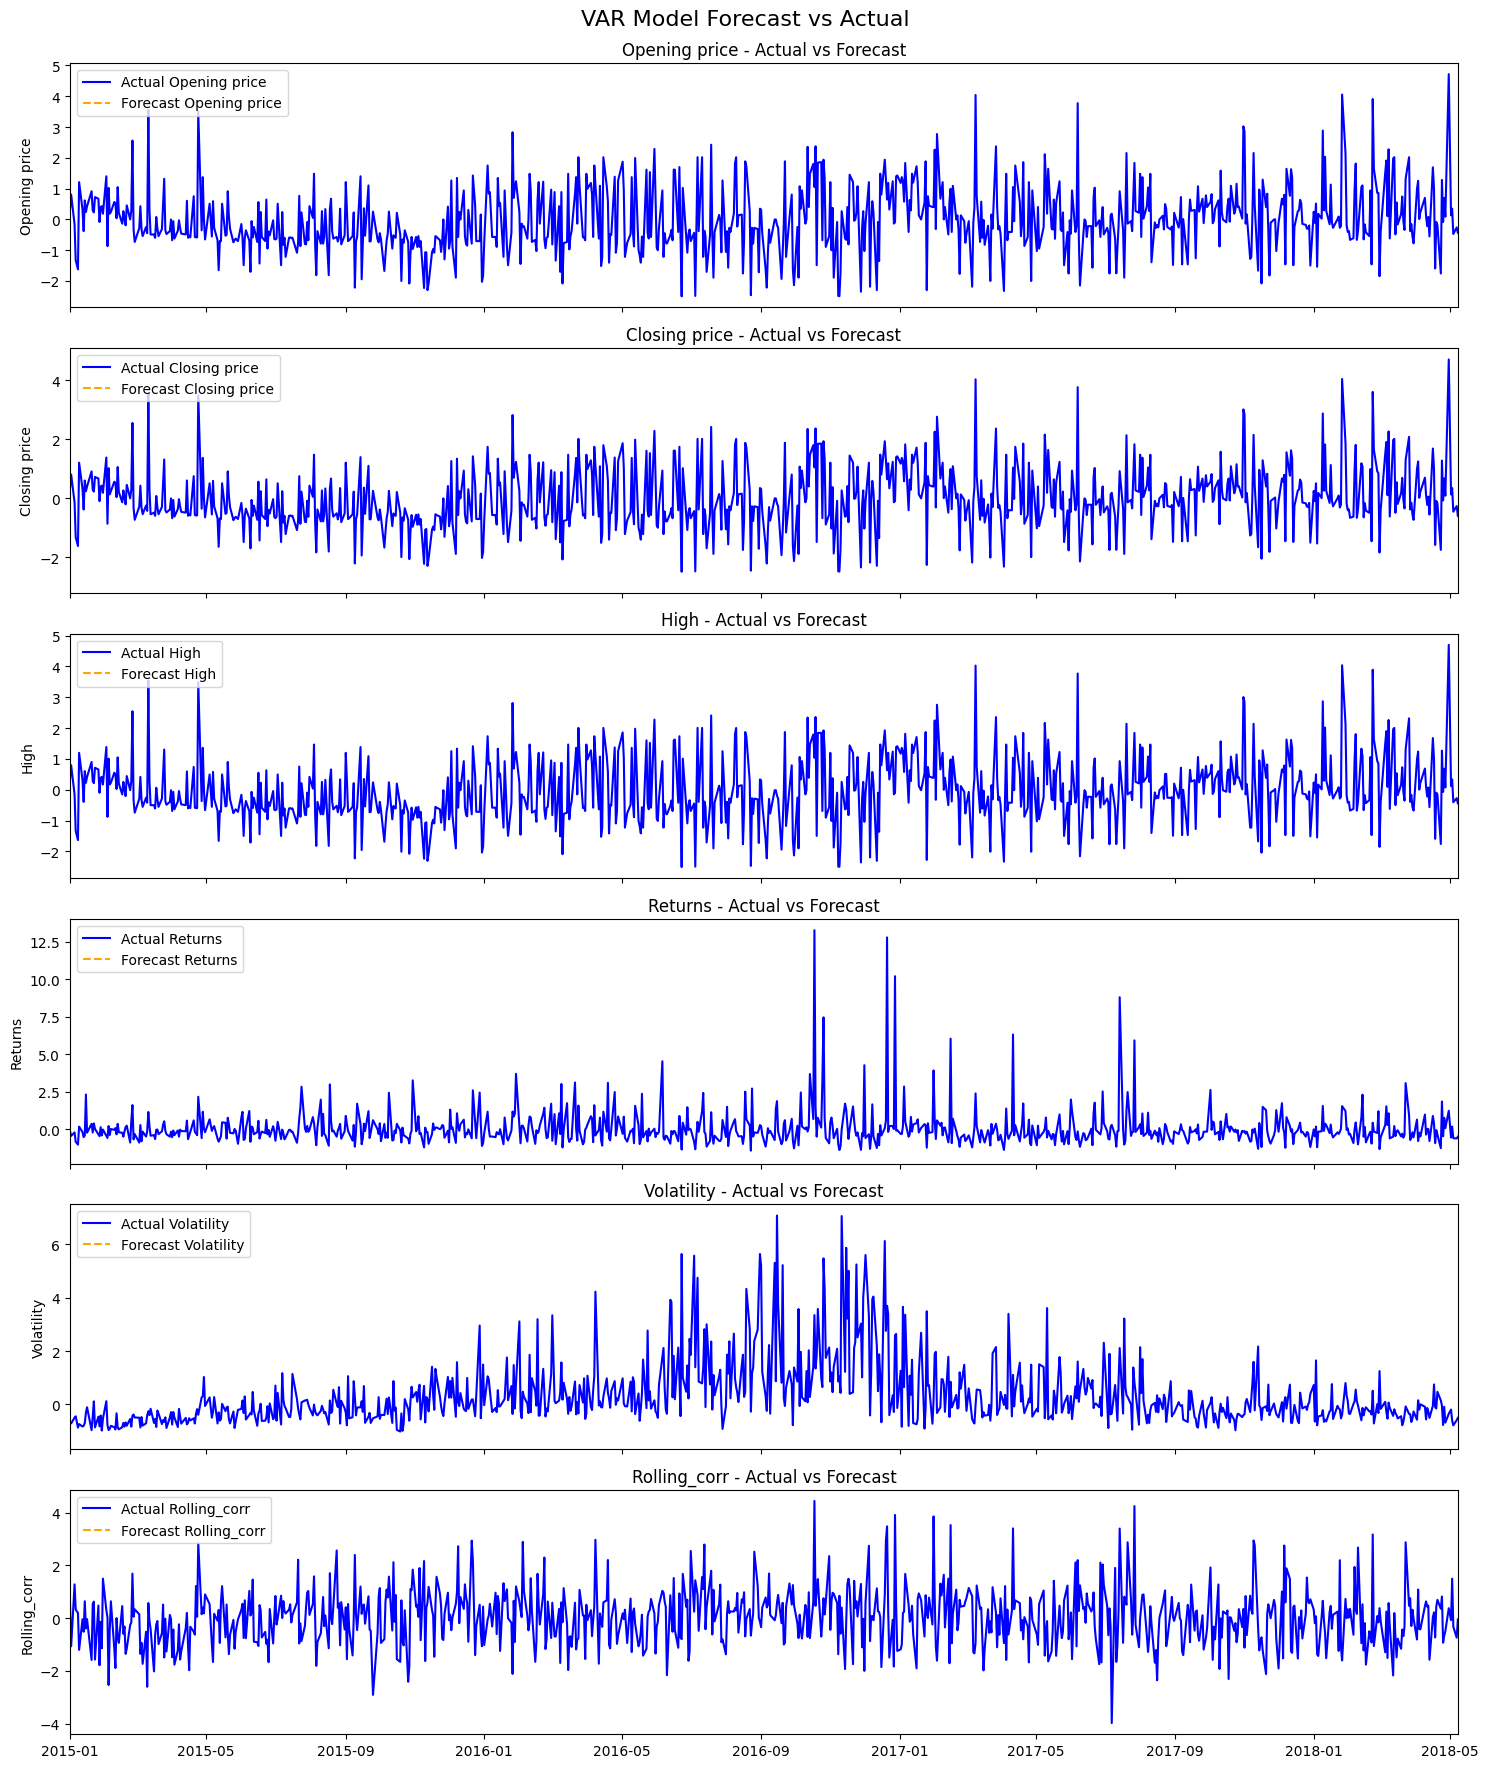

In [ ]:
train_data = train

variables = train_data.columns  # ['Opening price', 'Closing price', 'High', ...]
num_vars = len(variables)

plot_actual_vs_forecast(train_data, forecast_df, variables)

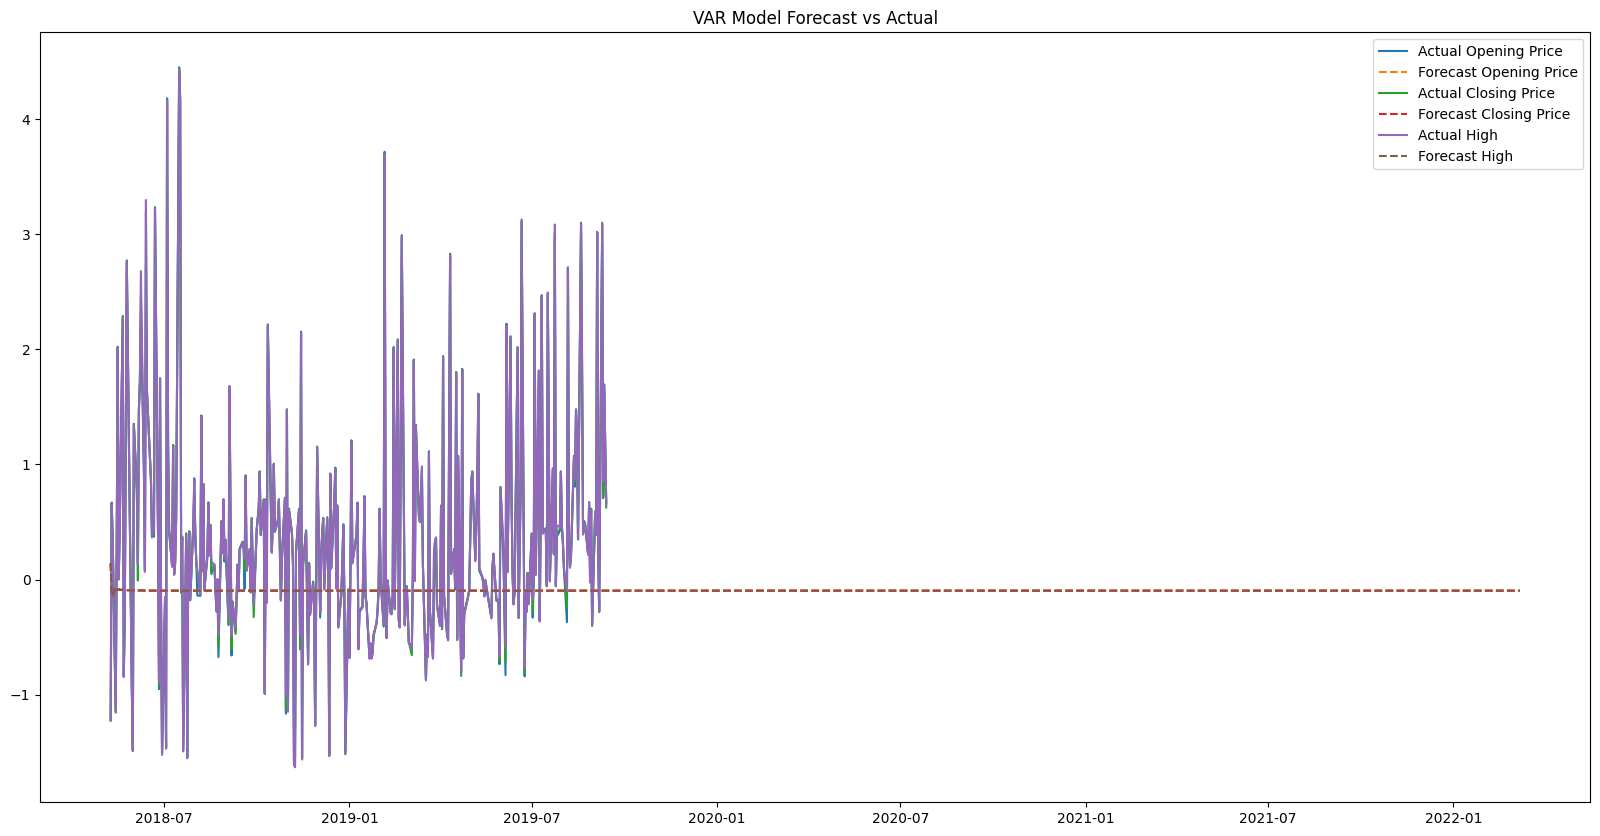

In [13]:
# Columns to plot
columns = ['Opening Price', 'Closing Price', 'High']

# Plotting and evaluating
plot_forecast_vs_actual(train, test, forecast_df, columns)


### Model Evaluation

In [14]:
rmses = evaluate_model(test, forecast_df)

Metrics for Opening Price:
  Root Mean Squared Error: 1.1039447167124232
  Mean Absolute Error: 0.7518058367462044
  Mean Absolute Percentage Error: 1.4785152211121397
  Recency RMSE (last 5 values): 1.714706551073159

Metrics for Closing Price:
  Root Mean Squared Error: 1.1032660823811176
  Mean Absolute Error: 0.7481816793629358
  Mean Absolute Percentage Error: 1.5137981983692685
  Recency RMSE (last 5 values): 1.7052262369279356

Metrics for High:
  Root Mean Squared Error: 1.108526099389269
  Mean Absolute Error: 0.7520222935207282
  Mean Absolute Percentage Error: 2.1689908950142938
  Recency RMSE (last 5 values): 1.7203723624743386

Metrics for Returns:
  Root Mean Squared Error: 0.6339664595954175
  Mean Absolute Error: 0.4775859035740238
  Mean Absolute Percentage Error: 1.111344135044443
  Recency RMSE (last 5 values): 0.7316083975525233

Metrics for Volatility:
  Root Mean Squared Error: 0.678620811273712
  Mean Absolute Error: 0.6242391799334397
  Mean Absolute Percentage 